# Hito 2: FL Inter-empresa

Se entrena un único modelo de manera federada entre las dos empresas. De esta forma, se mantendrá la privacidad de los datos de cada empresa PERO no internamente dentro de las empresas. Se medirá el rendimiento del modelo respecto a los baselines de empresas y centralizado.

El cuaderno es similar a Hito1-IntraEmpresa pero con las modificaciones necesarias para que cada cliente (dos en total) tiene los datos completos de una de las empresas.

# Configuración del escenario mediante Flower

Se hará uso del modulo 'simulation' (version 0.18.0 de la libería) que elimina las restricciones de escalabilidad que se tenían respecto a versiones anteriores

Es necesario instalar Flower con el extra de 'simulation'

In [1]:
# !pip install -U flwr["simulation"]

In [2]:
import os
import math

# Make TensorFlow logs less verbose
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import flwr as fl
import tensorflow as tf

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

from keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization
from tensorflow.keras.optimizers import Adadelta

from typing import Dict

from flwr.common.logger import log
from logging import INFO
from csv import writer


from numpy.random import seed
from tensorflow.keras.utils import set_random_seed

import matplotlib.pyplot as plt

In [3]:
class FlowerClient(fl.client.NumPyClient):
    def __init__(self, cid, model, x_train, y_train, x_val, y_val) -> None:
        self.cid = cid
        self.model = model
        self.x_train, self.y_train = x_train, y_train
        self.x_val, self.y_val = x_val, y_val

    def get_parameters(self):
        return self.model.get_weights()

    def fit(self, parameters, config):
        self.model.set_weights(parameters)
        
        seed(1)
        set_random_seed(2)
        
        self.model.fit(self.x_train, self.y_train,
                       epochs=int(config["epochs"]),
                       batch_size=32,
                       verbose=0)
        
        return self.model.get_weights(), len(self.x_train), {}

    def evaluate(self, parameters, config):
        self.model.set_weights(parameters)
        
        loss, acc = self.model.evaluate(self.x_val, self.y_val, verbose=0)
        
        return loss, len(self.x_val), {"accuracy": acc, "client": self.cid}

In [4]:
''' FUNCION PARA CARGAR LOS DATOS DE UN CLIENTE EN PARTICULAR '''
def prepare_model_data(client_file):
    df = pd.read_csv(client_file)
    
    train, test = train_test_split(df, test_size=0.30, random_state=42)
    
    X_train = train[['psd_delta', 'psd_theta', 'psd_alpha', 'psd_beta', 'psd_gamma','eog_blinks', 'eog_var']]
    X_test = test[['psd_delta', 'psd_theta', 'psd_alpha', 'psd_beta', 'psd_gamma','eog_blinks', 'eog_var']]
    y_train = train['y_class']
    y_test = test['y_class']
    
    scaler = StandardScaler()

    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    return X_train, X_test, y_train, y_test

''' FUNCION PARA CARGAR LOS DATOS DE UNA EMPRESA '''
def get_data_empresa(empresa):
    base_path = "./data/horizontal_v4"
    # Cargar y procesar datos de todos sus clientes
    clientes = os.listdir(f"{base_path}/{empresa}/")
    
    try:
        clientes.remove(UNSEEN_CLIENT)
    except:
        pass
    
    X_train, X_test, y_train, y_test = prepare_model_data(f'{base_path}/{empresa}/{clientes[0]}')
    
    for file in clientes[1:]:
        path = f'{base_path}/{empresa}/{file}'
        X_train_act, X_test_act, y_train_act, y_test_act = prepare_model_data(path)

        X_train = np.vstack((X_train, X_train_act))
        X_test = np.vstack((X_test, X_test_act))
        y_train = np.concatenate((y_train, y_train_act))
        y_test = np.concatenate((y_test, y_test_act))
        
    return X_train, X_test, y_train, y_test

In [5]:
def client_fn(cid: str) -> fl.client.Client:
    # Model best hyperparameters (Ver notebook Hito0-Optimizacion-Baseline)
    neurons = 36
    activation = "relu"
    learning_rate = 0.180165
    optimizer = Adadelta(learning_rate=learning_rate)
    
    input_shape = (7,)
    
    # Create model
    model = Sequential()
    
    model.add(Dense(neurons, input_shape=input_shape, activation=activation))
    
    model.add(BatchNormalization())
        
    model.add(Dense(neurons, activation=activation))
    model.add(Dense(neurons, activation=activation))
    model.add(Dense(neurons, activation=activation))
    
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    # Load data partition    
    x_train_cid, x_val_cid, y_train_cid, y_val_cid = get_data_empresa(cid)

    # Create and return client
    return FlowerClient(cid, model, x_train_cid, y_train_cid, x_val_cid, y_val_cid)

In [6]:
class SaveModelStrategy(fl.server.strategy.FedAvg):
    def aggregate_fit(self, rnd, results, failures):
        aggregated_weights = super().aggregate_fit(rnd, results, failures)
        
        if aggregated_weights is not None:
            # Save aggregated_weights
            print(f"Saving round {rnd} aggregated_weights...")
            np.savez(f"./rounds/hito2_v4-UC_{UNSEEN_CLIENT}-round-{rnd}-weights.npz", aggregated_weights)
            
        return aggregated_weights

    def aggregate_evaluate(self, rnd, results, failures):
        super_result = super().aggregate_evaluate(rnd, results, failures)
        
        log(
            INFO,
            f"round-{rnd}-EVALUATION"
        )
        
        accuracy = []
        data = {}
        for r in results:
            acc = r[1].metrics["accuracy"]
            client = r[1].metrics["client"]
            data[client] = acc
            accuracy.append(acc)
        
        df = pd.DataFrame(data, index=[0], columns=sorted(data.keys()))
        df.to_csv(f"./results/hito2.csv", mode='a', index=False, header=False)
        
        log(
            INFO,
            sorted(data.items())
        )
        
        np.array(accuracy)
        log(
            INFO,
            f"Aggregated accuracy: {np.mean(accuracy)} +- {np.std(accuracy)}"
        )
        
        return super_result

In [7]:
seed(1)
set_random_seed(2)

neurons = 36
activation = "relu"
learning_rate = 0.180165
optimizer = Adadelta(learning_rate=learning_rate)

input_shape = (7,)

# Create model
model = Sequential()

model.add(Dense(neurons, input_shape=input_shape, activation=activation))

model.add(BatchNormalization())

model.add(Dense(neurons, activation=activation))
model.add(Dense(neurons, activation=activation))
model.add(Dense(neurons, activation=activation))

model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Get model weights as a list of NumPy ndarray's
weights = model.get_weights()
# Serialize ndarrays to `Parameters`
parameters = fl.common.weights_to_parameters(weights)

In [8]:
# Configuracion de parametros para el entrenamiento desde el servidor
def fit_config(rnd: int) -> Dict[str, str]:
    config = {
        "round": str(rnd),
        "epochs": str(1) 
    }
    return config

In [13]:
# Ahora los clientes son las dos empresas
CLIENTS_IDS = ["empresa_1", "empresa_2", "empresa_3", "empresa_4"]

 # Se inicializa el fichero de resultados
header = CLIENTS_IDS

# Start Flower simulation
    # min_fit_clients y min_eval_clients se ponen al maximo de clientes disponibles ya que estamos en un escenario controlado
    
results_fed = pd.DataFrame(columns=["UC", "best_rnd", "acc"])    

seed(1)
set_random_seed(2)
for i in range(5,6):
    global UNSEEN_CLIENT 
    UNSEEN_CLIENT = f'cliente_{i}.csv'
    
    with open(f"./results/hito2.csv", 'w', ) as f:
        csv_writer = writer(f)
        csv_writer.writerow(header)
    
    fl.simulation.start_simulation(
        client_fn=client_fn,
        clients_ids=CLIENTS_IDS,
        client_resources={"num_cpus": 6},
        num_rounds=50,
        strategy=SaveModelStrategy(
            min_available_clients = len(CLIENTS_IDS),
            min_fit_clients = len(CLIENTS_IDS),
            min_eval_clients = len(CLIENTS_IDS),
            on_fit_config_fn = fit_config,
            on_evaluate_config_fn = fit_config,
            accept_failures=False,
            initial_parameters=parameters
        ),
    )
    
    df = pd.read_csv('./results/hito2.csv')
    df["mean"] = df.mean(numeric_only=True, axis=1)
    
    fed_res = {
        "UC": UNSEEN_CLIENT,
        "best_rnd": df["mean"].idxmax()+1,
        "acc": df["mean"].max()
    }
    
    results_fed = results_fed.append(fed_res, ignore_index=True)
    
results_fed.to_csv("./results/hito2_UCs_v2.csv", index=False, header=True)

INFO flower 2022-04-14 19:35:24,310 | app.py:144 | Ray initialized with resources: {'node:127.0.0.1': 1.0, 'CPU': 8.0, 'memory': 8609547879.0, 'object_store_memory': 4304773939.0, 'GPU': 1.0}
INFO flower 2022-04-14 19:35:24,310 | app.py:153 | Starting Flower simulation running: {'num_rounds': 50}
INFO flower 2022-04-14 19:35:24,311 | server.py:128 | Initializing global parameters
INFO flower 2022-04-14 19:35:24,311 | server.py:323 | Using initial parameters provided by strategy
INFO flower 2022-04-14 19:35:24,311 | server.py:130 | Evaluating initial parameters
INFO flower 2022-04-14 19:35:24,312 | server.py:143 | FL starting
DEBUG flower 2022-04-14 19:35:24,312 | server.py:265 | fit_round: strategy sampled 4 clients (out of 4)
DEBUG flower 2022-04-14 19:35:32,253 | server.py:277 | fit_round received 4 results and 0 failures
DEBUG flower 2022-04-14 19:35:32,263 | server.py:211 | evaluate_round: strategy sampled 4 clients (out of 4)


Saving round 1 aggregated_weights...


DEBUG flower 2022-04-14 19:35:33,613 | server.py:223 | evaluate_round received 4 results and 0 failures
INFO flower 2022-04-14 19:35:33,613 | 3765232772.py:15 | round-1-EVALUATION
INFO flower 2022-04-14 19:35:33,616 | 3765232772.py:31 | [('empresa_1', 0.6248348951339722), ('empresa_2', 0.5265700221061707), ('empresa_3', 0.6900858879089355), ('empresa_4', 0.6483516693115234)]
INFO flower 2022-04-14 19:35:33,616 | 3765232772.py:37 | Aggregated accuracy: 0.6224606186151505 +- 0.060091944637062016
DEBUG flower 2022-04-14 19:35:33,617 | server.py:265 | fit_round: strategy sampled 4 clients (out of 4)
DEBUG flower 2022-04-14 19:35:37,682 | server.py:277 | fit_round received 4 results and 0 failures
DEBUG flower 2022-04-14 19:35:37,692 | server.py:211 | evaluate_round: strategy sampled 4 clients (out of 4)


Saving round 2 aggregated_weights...


DEBUG flower 2022-04-14 19:35:39,144 | server.py:223 | evaluate_round received 4 results and 0 failures
INFO flower 2022-04-14 19:35:39,145 | 3765232772.py:15 | round-2-EVALUATION
INFO flower 2022-04-14 19:35:39,147 | 3765232772.py:31 | [('empresa_1', 0.6875825524330139), ('empresa_2', 0.6626409292221069), ('empresa_3', 0.6830601096153259), ('empresa_4', 0.6797488331794739)]
INFO flower 2022-04-14 19:35:39,148 | 3765232772.py:37 | Aggregated accuracy: 0.6782581061124802 +- 0.009435610977029173
DEBUG flower 2022-04-14 19:35:39,148 | server.py:265 | fit_round: strategy sampled 4 clients (out of 4)
DEBUG flower 2022-04-14 19:35:43,270 | server.py:277 | fit_round received 4 results and 0 failures
DEBUG flower 2022-04-14 19:35:43,280 | server.py:211 | evaluate_round: strategy sampled 4 clients (out of 4)


Saving round 3 aggregated_weights...


DEBUG flower 2022-04-14 19:35:44,631 | server.py:223 | evaluate_round received 4 results and 0 failures
INFO flower 2022-04-14 19:35:44,632 | 3765232772.py:15 | round-3-EVALUATION
INFO flower 2022-04-14 19:35:44,634 | 3765232772.py:31 | [('empresa_1', 0.7093791365623474), ('empresa_2', 0.7206119298934937), ('empresa_3', 0.6736924052238464), ('empresa_4', 0.6978021860122681)]
INFO flower 2022-04-14 19:35:44,634 | 3765232772.py:37 | Aggregated accuracy: 0.7003714144229889 +- 0.01738669024804617
DEBUG flower 2022-04-14 19:35:44,635 | server.py:265 | fit_round: strategy sampled 4 clients (out of 4)
DEBUG flower 2022-04-14 19:35:48,983 | server.py:277 | fit_round received 4 results and 0 failures
DEBUG flower 2022-04-14 19:35:48,993 | server.py:211 | evaluate_round: strategy sampled 4 clients (out of 4)


Saving round 4 aggregated_weights...


DEBUG flower 2022-04-14 19:35:50,421 | server.py:223 | evaluate_round received 4 results and 0 failures
INFO flower 2022-04-14 19:35:50,421 | 3765232772.py:15 | round-4-EVALUATION
INFO flower 2022-04-14 19:35:50,424 | 3765232772.py:31 | [('empresa_1', 0.7054161429405212), ('empresa_2', 0.7351046800613403), ('empresa_3', 0.6877439618110657), ('empresa_4', 0.6962323188781738)]
INFO flower 2022-04-14 19:35:50,424 | 3765232772.py:37 | Aggregated accuracy: 0.7061242759227753 +- 0.017860935287467912
DEBUG flower 2022-04-14 19:35:50,425 | server.py:265 | fit_round: strategy sampled 4 clients (out of 4)
DEBUG flower 2022-04-14 19:35:54,635 | server.py:277 | fit_round received 4 results and 0 failures
DEBUG flower 2022-04-14 19:35:54,645 | server.py:211 | evaluate_round: strategy sampled 4 clients (out of 4)


Saving round 5 aggregated_weights...


DEBUG flower 2022-04-14 19:35:55,966 | server.py:223 | evaluate_round received 4 results and 0 failures
INFO flower 2022-04-14 19:35:55,966 | 3765232772.py:15 | round-5-EVALUATION
INFO flower 2022-04-14 19:35:55,969 | 3765232772.py:31 | [('empresa_1', 0.7107001543045044), ('empresa_2', 0.7423510551452637), ('empresa_3', 0.6916471719741821), ('empresa_4', 0.7009419202804565)]
INFO flower 2022-04-14 19:35:55,969 | 3765232772.py:37 | Aggregated accuracy: 0.7114100754261017 +- 0.01909190167966299
DEBUG flower 2022-04-14 19:35:55,970 | server.py:265 | fit_round: strategy sampled 4 clients (out of 4)
DEBUG flower 2022-04-14 19:36:00,113 | server.py:277 | fit_round received 4 results and 0 failures
DEBUG flower 2022-04-14 19:36:00,123 | server.py:211 | evaluate_round: strategy sampled 4 clients (out of 4)


Saving round 6 aggregated_weights...


DEBUG flower 2022-04-14 19:36:01,887 | server.py:223 | evaluate_round received 4 results and 0 failures
INFO flower 2022-04-14 19:36:01,887 | 3765232772.py:15 | round-6-EVALUATION
INFO flower 2022-04-14 19:36:01,889 | 3765232772.py:31 | [('empresa_1', 0.7179656624794006), ('empresa_2', 0.7455716729164124), ('empresa_3', 0.7002341747283936), ('empresa_4', 0.7017268538475037)]
INFO flower 2022-04-14 19:36:01,890 | 3765232772.py:37 | Aggregated accuracy: 0.7163745909929276 +- 0.018235064724286112
DEBUG flower 2022-04-14 19:36:01,890 | server.py:265 | fit_round: strategy sampled 4 clients (out of 4)
DEBUG flower 2022-04-14 19:36:05,909 | server.py:277 | fit_round received 4 results and 0 failures
DEBUG flower 2022-04-14 19:36:05,919 | server.py:211 | evaluate_round: strategy sampled 4 clients (out of 4)


Saving round 7 aggregated_weights...


DEBUG flower 2022-04-14 19:36:07,291 | server.py:223 | evaluate_round received 4 results and 0 failures
INFO flower 2022-04-14 19:36:07,292 | 3765232772.py:15 | round-7-EVALUATION
INFO flower 2022-04-14 19:36:07,294 | 3765232772.py:31 | [('empresa_1', 0.7166446447372437), ('empresa_2', 0.7439613342285156), ('empresa_3', 0.7056986689567566), ('empresa_4', 0.7009419202804565)]
INFO flower 2022-04-14 19:36:07,294 | 3765232772.py:37 | Aggregated accuracy: 0.7168116420507431 +- 0.01667692952482931
DEBUG flower 2022-04-14 19:36:07,295 | server.py:265 | fit_round: strategy sampled 4 clients (out of 4)
DEBUG flower 2022-04-14 19:36:11,546 | server.py:277 | fit_round received 4 results and 0 failures
DEBUG flower 2022-04-14 19:36:11,556 | server.py:211 | evaluate_round: strategy sampled 4 clients (out of 4)


Saving round 8 aggregated_weights...


DEBUG flower 2022-04-14 19:36:12,917 | server.py:223 | evaluate_round received 4 results and 0 failures
INFO flower 2022-04-14 19:36:12,917 | 3765232772.py:15 | round-8-EVALUATION
INFO flower 2022-04-14 19:36:12,920 | 3765232772.py:31 | [('empresa_1', 0.7166446447372437), ('empresa_2', 0.739935576915741), ('empresa_3', 0.709601879119873), ('empresa_4', 0.7032967209815979)]
INFO flower 2022-04-14 19:36:12,920 | 3765232772.py:37 | Aggregated accuracy: 0.7173697054386139 +- 0.01385759977222269
DEBUG flower 2022-04-14 19:36:12,921 | server.py:265 | fit_round: strategy sampled 4 clients (out of 4)
DEBUG flower 2022-04-14 19:36:17,142 | server.py:277 | fit_round received 4 results and 0 failures
DEBUG flower 2022-04-14 19:36:17,151 | server.py:211 | evaluate_round: strategy sampled 4 clients (out of 4)


Saving round 9 aggregated_weights...


DEBUG flower 2022-04-14 19:36:18,485 | server.py:223 | evaluate_round received 4 results and 0 failures
INFO flower 2022-04-14 19:36:18,485 | 3765232772.py:15 | round-9-EVALUATION
INFO flower 2022-04-14 19:36:18,487 | 3765232772.py:31 | [('empresa_1', 0.7186261415481567), ('empresa_2', 0.7367149591445923), ('empresa_3', 0.7072599530220032), ('empresa_4', 0.7048665881156921)]
INFO flower 2022-04-14 19:36:18,488 | 3765232772.py:37 | Aggregated accuracy: 0.7168669104576111 +- 0.012583136514699542
DEBUG flower 2022-04-14 19:36:18,489 | server.py:265 | fit_round: strategy sampled 4 clients (out of 4)
DEBUG flower 2022-04-14 19:36:22,861 | server.py:277 | fit_round received 4 results and 0 failures
DEBUG flower 2022-04-14 19:36:22,871 | server.py:211 | evaluate_round: strategy sampled 4 clients (out of 4)


Saving round 10 aggregated_weights...


DEBUG flower 2022-04-14 19:36:24,322 | server.py:223 | evaluate_round received 4 results and 0 failures
INFO flower 2022-04-14 19:36:24,322 | 3765232772.py:15 | round-10-EVALUATION
INFO flower 2022-04-14 19:36:24,325 | 3765232772.py:31 | [('empresa_1', 0.7166446447372437), ('empresa_2', 0.727858304977417), ('empresa_3', 0.7103825211524963), ('empresa_4', 0.7080062627792358)]
INFO flower 2022-04-14 19:36:24,325 | 3765232772.py:37 | Aggregated accuracy: 0.7157229334115982 +- 0.007684136313760895
DEBUG flower 2022-04-14 19:36:24,326 | server.py:265 | fit_round: strategy sampled 4 clients (out of 4)
DEBUG flower 2022-04-14 19:36:28,414 | server.py:277 | fit_round received 4 results and 0 failures
DEBUG flower 2022-04-14 19:36:28,424 | server.py:211 | evaluate_round: strategy sampled 4 clients (out of 4)


Saving round 11 aggregated_weights...


DEBUG flower 2022-04-14 19:36:29,760 | server.py:223 | evaluate_round received 4 results and 0 failures
INFO flower 2022-04-14 19:36:29,761 | 3765232772.py:15 | round-11-EVALUATION
INFO flower 2022-04-14 19:36:29,763 | 3765232772.py:31 | [('empresa_1', 0.7179656624794006), ('empresa_2', 0.727053165435791), ('empresa_3', 0.7064793109893799), ('empresa_4', 0.708791196346283)]
INFO flower 2022-04-14 19:36:29,763 | 3765232772.py:37 | Aggregated accuracy: 0.7150723338127136 +- 0.008142548837258174
DEBUG flower 2022-04-14 19:36:29,764 | server.py:265 | fit_round: strategy sampled 4 clients (out of 4)
DEBUG flower 2022-04-14 19:36:34,030 | server.py:277 | fit_round received 4 results and 0 failures
DEBUG flower 2022-04-14 19:36:34,040 | server.py:211 | evaluate_round: strategy sampled 4 clients (out of 4)


Saving round 12 aggregated_weights...


DEBUG flower 2022-04-14 19:36:35,396 | server.py:223 | evaluate_round received 4 results and 0 failures
INFO flower 2022-04-14 19:36:35,396 | 3765232772.py:15 | round-12-EVALUATION
INFO flower 2022-04-14 19:36:35,398 | 3765232772.py:31 | [('empresa_1', 0.7199471592903137), ('empresa_2', 0.728663444519043), ('empresa_3', 0.7049180269241333), ('empresa_4', 0.7111459970474243)]
INFO flower 2022-04-14 19:36:35,399 | 3765232772.py:37 | Aggregated accuracy: 0.7161686569452286 +- 0.008974973325965124
DEBUG flower 2022-04-14 19:36:35,400 | server.py:265 | fit_round: strategy sampled 4 clients (out of 4)
DEBUG flower 2022-04-14 19:36:39,627 | server.py:277 | fit_round received 4 results and 0 failures
DEBUG flower 2022-04-14 19:36:39,637 | server.py:211 | evaluate_round: strategy sampled 4 clients (out of 4)


Saving round 13 aggregated_weights...


DEBUG flower 2022-04-14 19:36:40,971 | server.py:223 | evaluate_round received 4 results and 0 failures
INFO flower 2022-04-14 19:36:40,971 | 3765232772.py:15 | round-13-EVALUATION
INFO flower 2022-04-14 19:36:40,974 | 3765232772.py:31 | [('empresa_1', 0.7219286561012268), ('empresa_2', 0.727858304977417), ('empresa_3', 0.7072599530220032), ('empresa_4', 0.7119309306144714)]
INFO flower 2022-04-14 19:36:40,974 | 3765232772.py:37 | Aggregated accuracy: 0.7172444611787796 +- 0.008101224790794379
DEBUG flower 2022-04-14 19:36:40,975 | server.py:265 | fit_round: strategy sampled 4 clients (out of 4)
DEBUG flower 2022-04-14 19:36:45,106 | server.py:277 | fit_round received 4 results and 0 failures
DEBUG flower 2022-04-14 19:36:45,116 | server.py:211 | evaluate_round: strategy sampled 4 clients (out of 4)


Saving round 14 aggregated_weights...


DEBUG flower 2022-04-14 19:36:46,454 | server.py:223 | evaluate_round received 4 results and 0 failures
INFO flower 2022-04-14 19:36:46,455 | 3765232772.py:15 | round-14-EVALUATION
INFO flower 2022-04-14 19:36:46,457 | 3765232772.py:31 | [('empresa_1', 0.7245706915855408), ('empresa_2', 0.727858304977417), ('empresa_3', 0.7103825211524963), ('empresa_4', 0.7166405320167542)]
INFO flower 2022-04-14 19:36:46,457 | 3765232772.py:37 | Aggregated accuracy: 0.7198630124330521 +- 0.006825522705750655
DEBUG flower 2022-04-14 19:36:46,458 | server.py:265 | fit_round: strategy sampled 4 clients (out of 4)
DEBUG flower 2022-04-14 19:36:50,689 | server.py:277 | fit_round received 4 results and 0 failures
DEBUG flower 2022-04-14 19:36:50,699 | server.py:211 | evaluate_round: strategy sampled 4 clients (out of 4)


Saving round 15 aggregated_weights...


DEBUG flower 2022-04-14 19:36:52,215 | server.py:223 | evaluate_round received 4 results and 0 failures
INFO flower 2022-04-14 19:36:52,216 | 3765232772.py:15 | round-15-EVALUATION
INFO flower 2022-04-14 19:36:52,218 | 3765232772.py:31 | [('empresa_1', 0.7245706915855408), ('empresa_2', 0.727053165435791), ('empresa_3', 0.7088212370872498), ('empresa_4', 0.7182103395462036)]
INFO flower 2022-04-14 19:36:52,219 | 3765232772.py:37 | Aggregated accuracy: 0.7196638584136963 +- 0.0070419106847850995
DEBUG flower 2022-04-14 19:36:52,219 | server.py:265 | fit_round: strategy sampled 4 clients (out of 4)
DEBUG flower 2022-04-14 19:36:56,353 | server.py:277 | fit_round received 4 results and 0 failures
DEBUG flower 2022-04-14 19:36:56,362 | server.py:211 | evaluate_round: strategy sampled 4 clients (out of 4)


Saving round 16 aggregated_weights...


DEBUG flower 2022-04-14 19:36:57,768 | server.py:223 | evaluate_round received 4 results and 0 failures
INFO flower 2022-04-14 19:36:57,768 | 3765232772.py:15 | round-16-EVALUATION
INFO flower 2022-04-14 19:36:57,770 | 3765232772.py:31 | [('empresa_1', 0.725891649723053), ('empresa_2', 0.729468584060669), ('empresa_3', 0.7056986689567566), ('empresa_4', 0.7189952731132507)]
INFO flower 2022-04-14 19:36:57,771 | 3765232772.py:37 | Aggregated accuracy: 0.7200135439634323 +- 0.009081608235091361
DEBUG flower 2022-04-14 19:36:57,771 | server.py:265 | fit_round: strategy sampled 4 clients (out of 4)
DEBUG flower 2022-04-14 19:37:02,043 | server.py:277 | fit_round received 4 results and 0 failures
DEBUG flower 2022-04-14 19:37:02,053 | server.py:211 | evaluate_round: strategy sampled 4 clients (out of 4)


Saving round 17 aggregated_weights...


DEBUG flower 2022-04-14 19:37:03,517 | server.py:223 | evaluate_round received 4 results and 0 failures
INFO flower 2022-04-14 19:37:03,518 | 3765232772.py:15 | round-17-EVALUATION
INFO flower 2022-04-14 19:37:03,520 | 3765232772.py:31 | [('empresa_1', 0.7278732061386108), ('empresa_2', 0.728663444519043), ('empresa_3', 0.7033567428588867), ('empresa_4', 0.7174254059791565)]
INFO flower 2022-04-14 19:37:03,521 | 3765232772.py:37 | Aggregated accuracy: 0.7193296998739243 +- 0.010233181072336546
DEBUG flower 2022-04-14 19:37:03,521 | server.py:265 | fit_round: strategy sampled 4 clients (out of 4)
DEBUG flower 2022-04-14 19:37:07,621 | server.py:277 | fit_round received 4 results and 0 failures
DEBUG flower 2022-04-14 19:37:07,632 | server.py:211 | evaluate_round: strategy sampled 4 clients (out of 4)


Saving round 18 aggregated_weights...


DEBUG flower 2022-04-14 19:37:09,005 | server.py:223 | evaluate_round received 4 results and 0 failures
INFO flower 2022-04-14 19:37:09,006 | 3765232772.py:15 | round-18-EVALUATION
INFO flower 2022-04-14 19:37:09,008 | 3765232772.py:31 | [('empresa_1', 0.72721266746521), ('empresa_2', 0.727858304977417), ('empresa_3', 0.7002341747283936), ('empresa_4', 0.7166405320167542)]
INFO flower 2022-04-14 19:37:09,009 | 3765232772.py:37 | Aggregated accuracy: 0.7179864197969437 +- 0.011175099350155274
DEBUG flower 2022-04-14 19:37:09,009 | server.py:265 | fit_round: strategy sampled 4 clients (out of 4)
DEBUG flower 2022-04-14 19:37:13,373 | server.py:277 | fit_round received 4 results and 0 failures
DEBUG flower 2022-04-14 19:37:13,383 | server.py:211 | evaluate_round: strategy sampled 4 clients (out of 4)


Saving round 19 aggregated_weights...


DEBUG flower 2022-04-14 19:37:14,770 | server.py:223 | evaluate_round received 4 results and 0 failures
INFO flower 2022-04-14 19:37:14,771 | 3765232772.py:15 | round-19-EVALUATION
INFO flower 2022-04-14 19:37:14,773 | 3765232772.py:31 | [('empresa_1', 0.7278732061386108), ('empresa_2', 0.7262479662895203), ('empresa_3', 0.7017954587936401), ('empresa_4', 0.7189952731132507)]
INFO flower 2022-04-14 19:37:14,774 | 3765232772.py:37 | Aggregated accuracy: 0.7187279760837555 +- 0.010331590813290324
DEBUG flower 2022-04-14 19:37:14,774 | server.py:265 | fit_round: strategy sampled 4 clients (out of 4)
DEBUG flower 2022-04-14 19:37:19,133 | server.py:277 | fit_round received 4 results and 0 failures
DEBUG flower 2022-04-14 19:37:19,143 | server.py:211 | evaluate_round: strategy sampled 4 clients (out of 4)


Saving round 20 aggregated_weights...


DEBUG flower 2022-04-14 19:37:20,548 | server.py:223 | evaluate_round received 4 results and 0 failures
INFO flower 2022-04-14 19:37:20,548 | 3765232772.py:15 | round-20-EVALUATION
INFO flower 2022-04-14 19:37:20,551 | 3765232772.py:31 | [('empresa_1', 0.7298547029495239), ('empresa_2', 0.7254428267478943), ('empresa_3', 0.6994535326957703), ('empresa_4', 0.720565140247345)]
INFO flower 2022-04-14 19:37:20,551 | 3765232772.py:37 | Aggregated accuracy: 0.7188290506601334 +- 0.01165902811116522
DEBUG flower 2022-04-14 19:37:20,552 | server.py:265 | fit_round: strategy sampled 4 clients (out of 4)
DEBUG flower 2022-04-14 19:37:24,815 | server.py:277 | fit_round received 4 results and 0 failures
DEBUG flower 2022-04-14 19:37:24,825 | server.py:211 | evaluate_round: strategy sampled 4 clients (out of 4)


Saving round 21 aggregated_weights...


DEBUG flower 2022-04-14 19:37:26,385 | server.py:223 | evaluate_round received 4 results and 0 failures
INFO flower 2022-04-14 19:37:26,386 | 3765232772.py:15 | round-21-EVALUATION
INFO flower 2022-04-14 19:37:26,388 | 3765232772.py:31 | [('empresa_1', 0.7285336852073669), ('empresa_2', 0.7246376872062683), ('empresa_3', 0.6978922486305237), ('empresa_4', 0.720565140247345)]
INFO flower 2022-04-14 19:37:26,389 | 3765232772.py:37 | Aggregated accuracy: 0.717907190322876 +- 0.01189416422638339
DEBUG flower 2022-04-14 19:37:26,389 | server.py:265 | fit_round: strategy sampled 4 clients (out of 4)
DEBUG flower 2022-04-14 19:37:30,702 | server.py:277 | fit_round received 4 results and 0 failures
DEBUG flower 2022-04-14 19:37:30,712 | server.py:211 | evaluate_round: strategy sampled 4 clients (out of 4)


Saving round 22 aggregated_weights...


DEBUG flower 2022-04-14 19:37:32,106 | server.py:223 | evaluate_round received 4 results and 0 failures
INFO flower 2022-04-14 19:37:32,106 | 3765232772.py:15 | round-22-EVALUATION
INFO flower 2022-04-14 19:37:32,109 | 3765232772.py:31 | [('empresa_1', 0.729194164276123), ('empresa_2', 0.7246376872062683), ('empresa_3', 0.6971116065979004), ('empresa_4', 0.720565140247345)]
INFO flower 2022-04-14 19:37:32,109 | 3765232772.py:37 | Aggregated accuracy: 0.7178771495819092 +- 0.012371466766289422
DEBUG flower 2022-04-14 19:37:32,110 | server.py:265 | fit_round: strategy sampled 4 clients (out of 4)
DEBUG flower 2022-04-14 19:37:36,457 | server.py:277 | fit_round received 4 results and 0 failures
DEBUG flower 2022-04-14 19:37:36,467 | server.py:211 | evaluate_round: strategy sampled 4 clients (out of 4)


Saving round 23 aggregated_weights...


DEBUG flower 2022-04-14 19:37:37,852 | server.py:223 | evaluate_round received 4 results and 0 failures
INFO flower 2022-04-14 19:37:37,852 | 3765232772.py:15 | round-23-EVALUATION
INFO flower 2022-04-14 19:37:37,855 | 3765232772.py:31 | [('empresa_1', 0.7278732061386108), ('empresa_2', 0.7238325476646423), ('empresa_3', 0.7002341747283936), ('empresa_4', 0.720565140247345)]
INFO flower 2022-04-14 19:37:37,855 | 3765232772.py:37 | Aggregated accuracy: 0.7181262671947479 +- 0.010649407614601723
DEBUG flower 2022-04-14 19:37:37,856 | server.py:265 | fit_round: strategy sampled 4 clients (out of 4)
DEBUG flower 2022-04-14 19:37:42,137 | server.py:277 | fit_round received 4 results and 0 failures
DEBUG flower 2022-04-14 19:37:42,146 | server.py:211 | evaluate_round: strategy sampled 4 clients (out of 4)


Saving round 24 aggregated_weights...


DEBUG flower 2022-04-14 19:37:43,543 | server.py:223 | evaluate_round received 4 results and 0 failures
INFO flower 2022-04-14 19:37:43,543 | 3765232772.py:15 | round-24-EVALUATION
INFO flower 2022-04-14 19:37:43,546 | 3765232772.py:31 | [('empresa_1', 0.72721266746521), ('empresa_2', 0.7246376872062683), ('empresa_3', 0.7017954587936401), ('empresa_4', 0.720565140247345)]
INFO flower 2022-04-14 19:37:43,546 | 3765232772.py:37 | Aggregated accuracy: 0.7185527384281158 +- 0.009960887942225532
DEBUG flower 2022-04-14 19:37:43,547 | server.py:265 | fit_round: strategy sampled 4 clients (out of 4)
DEBUG flower 2022-04-14 19:37:47,772 | server.py:277 | fit_round received 4 results and 0 failures
DEBUG flower 2022-04-14 19:37:47,783 | server.py:211 | evaluate_round: strategy sampled 4 clients (out of 4)


Saving round 25 aggregated_weights...


DEBUG flower 2022-04-14 19:37:49,271 | server.py:223 | evaluate_round received 4 results and 0 failures
INFO flower 2022-04-14 19:37:49,271 | 3765232772.py:15 | round-25-EVALUATION
INFO flower 2022-04-14 19:37:49,274 | 3765232772.py:31 | [('empresa_1', 0.7285336852073669), ('empresa_2', 0.7246376872062683), ('empresa_3', 0.7010148167610168), ('empresa_4', 0.720565140247345)]
INFO flower 2022-04-14 19:37:49,274 | 3765232772.py:37 | Aggregated accuracy: 0.7186878323554993 +- 0.010585383274230743
DEBUG flower 2022-04-14 19:37:49,274 | server.py:265 | fit_round: strategy sampled 4 clients (out of 4)
DEBUG flower 2022-04-14 19:37:53,505 | server.py:277 | fit_round received 4 results and 0 failures
DEBUG flower 2022-04-14 19:37:53,515 | server.py:211 | evaluate_round: strategy sampled 4 clients (out of 4)


Saving round 26 aggregated_weights...


DEBUG flower 2022-04-14 19:37:54,878 | server.py:223 | evaluate_round received 4 results and 0 failures
INFO flower 2022-04-14 19:37:54,878 | 3765232772.py:15 | round-26-EVALUATION
INFO flower 2022-04-14 19:37:54,880 | 3765232772.py:31 | [('empresa_1', 0.7298547029495239), ('empresa_2', 0.7230273485183716), ('empresa_3', 0.7010148167610168), ('empresa_4', 0.720565140247345)]
INFO flower 2022-04-14 19:37:54,881 | 3765232772.py:37 | Aggregated accuracy: 0.7186155021190643 +- 0.010716450413531487
DEBUG flower 2022-04-14 19:37:54,882 | server.py:265 | fit_round: strategy sampled 4 clients (out of 4)
DEBUG flower 2022-04-14 19:37:59,189 | server.py:277 | fit_round received 4 results and 0 failures
DEBUG flower 2022-04-14 19:37:59,199 | server.py:211 | evaluate_round: strategy sampled 4 clients (out of 4)


Saving round 27 aggregated_weights...


DEBUG flower 2022-04-14 19:38:00,606 | server.py:223 | evaluate_round received 4 results and 0 failures
INFO flower 2022-04-14 19:38:00,607 | 3765232772.py:15 | round-27-EVALUATION
INFO flower 2022-04-14 19:38:00,609 | 3765232772.py:31 | [('empresa_1', 0.7311757206916809), ('empresa_2', 0.7254428267478943), ('empresa_3', 0.7025761008262634), ('empresa_4', 0.7197802066802979)]
INFO flower 2022-04-14 19:38:00,610 | 3765232772.py:37 | Aggregated accuracy: 0.7197437137365341 +- 0.010699286622371334
DEBUG flower 2022-04-14 19:38:00,610 | server.py:265 | fit_round: strategy sampled 4 clients (out of 4)
DEBUG flower 2022-04-14 19:38:04,956 | server.py:277 | fit_round received 4 results and 0 failures
DEBUG flower 2022-04-14 19:38:04,965 | server.py:211 | evaluate_round: strategy sampled 4 clients (out of 4)


Saving round 28 aggregated_weights...


DEBUG flower 2022-04-14 19:38:06,325 | server.py:223 | evaluate_round received 4 results and 0 failures
INFO flower 2022-04-14 19:38:06,326 | 3765232772.py:15 | round-28-EVALUATION
INFO flower 2022-04-14 19:38:06,328 | 3765232772.py:31 | [('empresa_1', 0.731836199760437), ('empresa_2', 0.7262479662895203), ('empresa_3', 0.7033567428588867), ('empresa_4', 0.7197802066802979)]
INFO flower 2022-04-14 19:38:06,328 | 3765232772.py:37 | Aggregated accuracy: 0.7203052788972855 +- 0.010674809647858403
DEBUG flower 2022-04-14 19:38:06,329 | server.py:265 | fit_round: strategy sampled 4 clients (out of 4)
DEBUG flower 2022-04-14 19:38:10,689 | server.py:277 | fit_round received 4 results and 0 failures
DEBUG flower 2022-04-14 19:38:10,699 | server.py:211 | evaluate_round: strategy sampled 4 clients (out of 4)


Saving round 29 aggregated_weights...


DEBUG flower 2022-04-14 19:38:12,385 | server.py:223 | evaluate_round received 4 results and 0 failures
INFO flower 2022-04-14 19:38:12,386 | 3765232772.py:15 | round-29-EVALUATION
INFO flower 2022-04-14 19:38:12,388 | 3765232772.py:31 | [('empresa_1', 0.7324966788291931), ('empresa_2', 0.7254428267478943), ('empresa_3', 0.70413738489151), ('empresa_4', 0.7189952731132507)]
INFO flower 2022-04-14 19:38:12,389 | 3765232772.py:37 | Aggregated accuracy: 0.720268040895462 +- 0.010465849168582647
DEBUG flower 2022-04-14 19:38:12,389 | server.py:265 | fit_round: strategy sampled 4 clients (out of 4)
DEBUG flower 2022-04-14 19:38:16,343 | server.py:277 | fit_round received 4 results and 0 failures
DEBUG flower 2022-04-14 19:38:16,354 | server.py:211 | evaluate_round: strategy sampled 4 clients (out of 4)


Saving round 30 aggregated_weights...


DEBUG flower 2022-04-14 19:38:17,715 | server.py:223 | evaluate_round received 4 results and 0 failures
INFO flower 2022-04-14 19:38:17,715 | 3765232772.py:15 | round-30-EVALUATION
INFO flower 2022-04-14 19:38:17,717 | 3765232772.py:31 | [('empresa_1', 0.733157217502594), ('empresa_2', 0.7230273485183716), ('empresa_3', 0.7025761008262634), ('empresa_4', 0.7189952731132507)]
INFO flower 2022-04-14 19:38:17,718 | 3765232772.py:37 | Aggregated accuracy: 0.7194389849901199 +- 0.011018393696797463
DEBUG flower 2022-04-14 19:38:17,718 | server.py:265 | fit_round: strategy sampled 4 clients (out of 4)
DEBUG flower 2022-04-14 19:38:21,951 | server.py:277 | fit_round received 4 results and 0 failures
DEBUG flower 2022-04-14 19:38:21,961 | server.py:211 | evaluate_round: strategy sampled 4 clients (out of 4)


Saving round 31 aggregated_weights...


DEBUG flower 2022-04-14 19:38:23,293 | server.py:223 | evaluate_round received 4 results and 0 failures
INFO flower 2022-04-14 19:38:23,293 | 3765232772.py:15 | round-31-EVALUATION
INFO flower 2022-04-14 19:38:23,295 | 3765232772.py:31 | [('empresa_1', 0.733157217502594), ('empresa_2', 0.7230273485183716), ('empresa_3', 0.7025761008262634), ('empresa_4', 0.7189952731132507)]
INFO flower 2022-04-14 19:38:23,296 | 3765232772.py:37 | Aggregated accuracy: 0.7194389849901199 +- 0.011018393696797463
DEBUG flower 2022-04-14 19:38:23,296 | server.py:265 | fit_round: strategy sampled 4 clients (out of 4)
DEBUG flower 2022-04-14 19:38:27,447 | server.py:277 | fit_round received 4 results and 0 failures
DEBUG flower 2022-04-14 19:38:27,464 | server.py:211 | evaluate_round: strategy sampled 4 clients (out of 4)


Saving round 32 aggregated_weights...


DEBUG flower 2022-04-14 19:38:28,786 | server.py:223 | evaluate_round received 4 results and 0 failures
INFO flower 2022-04-14 19:38:28,786 | 3765232772.py:15 | round-32-EVALUATION
INFO flower 2022-04-14 19:38:28,788 | 3765232772.py:31 | [('empresa_1', 0.7351387143135071), ('empresa_2', 0.7230273485183716), ('empresa_3', 0.7010148167610168), ('empresa_4', 0.7166405320167542)]
INFO flower 2022-04-14 19:38:28,789 | 3765232772.py:37 | Aggregated accuracy: 0.7189553529024124 +- 0.012305522821399127
DEBUG flower 2022-04-14 19:38:28,789 | server.py:265 | fit_round: strategy sampled 4 clients (out of 4)
DEBUG flower 2022-04-14 19:38:32,888 | server.py:277 | fit_round received 4 results and 0 failures
DEBUG flower 2022-04-14 19:38:32,898 | server.py:211 | evaluate_round: strategy sampled 4 clients (out of 4)


Saving round 33 aggregated_weights...


DEBUG flower 2022-04-14 19:38:34,358 | server.py:223 | evaluate_round received 4 results and 0 failures
INFO flower 2022-04-14 19:38:34,359 | 3765232772.py:15 | round-33-EVALUATION
INFO flower 2022-04-14 19:38:34,361 | 3765232772.py:31 | [('empresa_1', 0.7357991933822632), ('empresa_2', 0.7222222089767456), ('empresa_3', 0.7002341747283936), ('empresa_4', 0.715855598449707)]
INFO flower 2022-04-14 19:38:34,361 | 3765232772.py:37 | Aggregated accuracy: 0.7185277938842773 +- 0.012784239063741138
DEBUG flower 2022-04-14 19:38:34,362 | server.py:265 | fit_round: strategy sampled 4 clients (out of 4)
DEBUG flower 2022-04-14 19:38:38,444 | server.py:277 | fit_round received 4 results and 0 failures
DEBUG flower 2022-04-14 19:38:38,461 | server.py:211 | evaluate_round: strategy sampled 4 clients (out of 4)


Saving round 34 aggregated_weights...


DEBUG flower 2022-04-14 19:38:39,792 | server.py:223 | evaluate_round received 4 results and 0 failures
INFO flower 2022-04-14 19:38:39,792 | 3765232772.py:15 | round-34-EVALUATION
INFO flower 2022-04-14 19:38:39,794 | 3765232772.py:31 | [('empresa_1', 0.7351387143135071), ('empresa_2', 0.7214170694351196), ('empresa_3', 0.7002341747283936), ('empresa_4', 0.7142857313156128)]
INFO flower 2022-04-14 19:38:39,795 | 3765232772.py:37 | Aggregated accuracy: 0.7177689224481583 +- 0.012595819186794187
DEBUG flower 2022-04-14 19:38:39,795 | server.py:265 | fit_round: strategy sampled 4 clients (out of 4)
DEBUG flower 2022-04-14 19:38:44,016 | server.py:277 | fit_round received 4 results and 0 failures
DEBUG flower 2022-04-14 19:38:44,032 | server.py:211 | evaluate_round: strategy sampled 4 clients (out of 4)


Saving round 35 aggregated_weights...


DEBUG flower 2022-04-14 19:38:45,473 | server.py:223 | evaluate_round received 4 results and 0 failures
INFO flower 2022-04-14 19:38:45,473 | 3765232772.py:15 | round-35-EVALUATION
INFO flower 2022-04-14 19:38:45,475 | 3765232772.py:31 | [('empresa_1', 0.7351387143135071), ('empresa_2', 0.7230273485183716), ('empresa_3', 0.7010148167610168), ('empresa_4', 0.7142857313156128)]
INFO flower 2022-04-14 19:38:45,476 | 3765232772.py:37 | Aggregated accuracy: 0.7183666527271271 +- 0.012457570650789025
DEBUG flower 2022-04-14 19:38:45,476 | server.py:265 | fit_round: strategy sampled 4 clients (out of 4)
DEBUG flower 2022-04-14 19:38:49,902 | server.py:277 | fit_round received 4 results and 0 failures
DEBUG flower 2022-04-14 19:38:49,913 | server.py:211 | evaluate_round: strategy sampled 4 clients (out of 4)


Saving round 36 aggregated_weights...


DEBUG flower 2022-04-14 19:38:51,281 | server.py:223 | evaluate_round received 4 results and 0 failures
INFO flower 2022-04-14 19:38:51,281 | 3765232772.py:15 | round-36-EVALUATION
INFO flower 2022-04-14 19:38:51,284 | 3765232772.py:31 | [('empresa_1', 0.7364597320556641), ('empresa_2', 0.7222222089767456), ('empresa_3', 0.6978922486305237), ('empresa_4', 0.7142857313156128)]
INFO flower 2022-04-14 19:38:51,284 | 3765232772.py:37 | Aggregated accuracy: 0.7177149802446365 +- 0.013931809539350307
DEBUG flower 2022-04-14 19:38:51,285 | server.py:265 | fit_round: strategy sampled 4 clients (out of 4)
DEBUG flower 2022-04-14 19:38:55,565 | server.py:277 | fit_round received 4 results and 0 failures
DEBUG flower 2022-04-14 19:38:55,574 | server.py:211 | evaluate_round: strategy sampled 4 clients (out of 4)


Saving round 37 aggregated_weights...


DEBUG flower 2022-04-14 19:38:57,069 | server.py:223 | evaluate_round received 4 results and 0 failures
INFO flower 2022-04-14 19:38:57,070 | 3765232772.py:15 | round-37-EVALUATION
INFO flower 2022-04-14 19:38:57,072 | 3765232772.py:31 | [('empresa_1', 0.7371202111244202), ('empresa_2', 0.7246376872062683), ('empresa_3', 0.6978922486305237), ('empresa_4', 0.7142857313156128)]
INFO flower 2022-04-14 19:38:57,073 | 3765232772.py:37 | Aggregated accuracy: 0.7184839695692062 +- 0.01437725561182909
DEBUG flower 2022-04-14 19:38:57,073 | server.py:265 | fit_round: strategy sampled 4 clients (out of 4)
DEBUG flower 2022-04-14 19:39:01,343 | server.py:277 | fit_round received 4 results and 0 failures
DEBUG flower 2022-04-14 19:39:01,354 | server.py:211 | evaluate_round: strategy sampled 4 clients (out of 4)


Saving round 38 aggregated_weights...


DEBUG flower 2022-04-14 19:39:02,809 | server.py:223 | evaluate_round received 4 results and 0 failures
INFO flower 2022-04-14 19:39:02,810 | 3765232772.py:15 | round-38-EVALUATION
INFO flower 2022-04-14 19:39:02,812 | 3765232772.py:31 | [('empresa_1', 0.7371202111244202), ('empresa_2', 0.7262479662895203), ('empresa_3', 0.6963309645652771), ('empresa_4', 0.7135007977485657)]
INFO flower 2022-04-14 19:39:02,813 | 3765232772.py:37 | Aggregated accuracy: 0.7182999849319458 +- 0.015190797996554308
DEBUG flower 2022-04-14 19:39:02,813 | server.py:265 | fit_round: strategy sampled 4 clients (out of 4)
DEBUG flower 2022-04-14 19:39:07,165 | server.py:277 | fit_round received 4 results and 0 failures
DEBUG flower 2022-04-14 19:39:07,183 | server.py:211 | evaluate_round: strategy sampled 4 clients (out of 4)


Saving round 39 aggregated_weights...


DEBUG flower 2022-04-14 19:39:08,644 | server.py:223 | evaluate_round received 4 results and 0 failures
INFO flower 2022-04-14 19:39:08,644 | 3765232772.py:15 | round-39-EVALUATION
INFO flower 2022-04-14 19:39:08,646 | 3765232772.py:31 | [('empresa_1', 0.7377806901931763), ('empresa_2', 0.727858304977417), ('empresa_3', 0.6963309645652771), ('empresa_4', 0.7135007977485657)]
INFO flower 2022-04-14 19:39:08,647 | 3765232772.py:37 | Aggregated accuracy: 0.718867689371109 +- 0.015614418494918653
DEBUG flower 2022-04-14 19:39:08,647 | server.py:265 | fit_round: strategy sampled 4 clients (out of 4)
DEBUG flower 2022-04-14 19:39:13,129 | server.py:277 | fit_round received 4 results and 0 failures
DEBUG flower 2022-04-14 19:39:13,139 | server.py:211 | evaluate_round: strategy sampled 4 clients (out of 4)


Saving round 40 aggregated_weights...


DEBUG flower 2022-04-14 19:39:14,556 | server.py:223 | evaluate_round received 4 results and 0 failures
INFO flower 2022-04-14 19:39:14,557 | 3765232772.py:15 | round-40-EVALUATION
INFO flower 2022-04-14 19:39:14,559 | 3765232772.py:31 | [('empresa_1', 0.7384412288665771), ('empresa_2', 0.727858304977417), ('empresa_3', 0.6947697401046753), ('empresa_4', 0.7127158641815186)]
INFO flower 2022-04-14 19:39:14,560 | 3765232772.py:37 | Aggregated accuracy: 0.718446284532547 +- 0.01644536713804285
DEBUG flower 2022-04-14 19:39:14,560 | server.py:265 | fit_round: strategy sampled 4 clients (out of 4)
DEBUG flower 2022-04-14 19:39:18,897 | server.py:277 | fit_round received 4 results and 0 failures
DEBUG flower 2022-04-14 19:39:18,908 | server.py:211 | evaluate_round: strategy sampled 4 clients (out of 4)


Saving round 41 aggregated_weights...


DEBUG flower 2022-04-14 19:39:20,463 | server.py:223 | evaluate_round received 4 results and 0 failures
INFO flower 2022-04-14 19:39:20,464 | 3765232772.py:15 | round-41-EVALUATION
INFO flower 2022-04-14 19:39:20,466 | 3765232772.py:31 | [('empresa_1', 0.7391017079353333), ('empresa_2', 0.727053165435791), ('empresa_3', 0.693989098072052), ('empresa_4', 0.7119309306144714)]
INFO flower 2022-04-14 19:39:20,467 | 3765232772.py:37 | Aggregated accuracy: 0.7180187255144119 +- 0.016886366499459293
DEBUG flower 2022-04-14 19:39:20,467 | server.py:265 | fit_round: strategy sampled 4 clients (out of 4)
DEBUG flower 2022-04-14 19:39:24,933 | server.py:277 | fit_round received 4 results and 0 failures
DEBUG flower 2022-04-14 19:39:24,950 | server.py:211 | evaluate_round: strategy sampled 4 clients (out of 4)


Saving round 42 aggregated_weights...


DEBUG flower 2022-04-14 19:39:26,451 | server.py:223 | evaluate_round received 4 results and 0 failures
INFO flower 2022-04-14 19:39:26,451 | 3765232772.py:15 | round-42-EVALUATION
INFO flower 2022-04-14 19:39:26,453 | 3765232772.py:31 | [('empresa_1', 0.7397622466087341), ('empresa_2', 0.7262479662895203), ('empresa_3', 0.6947697401046753), ('empresa_4', 0.7095761299133301)]
INFO flower 2022-04-14 19:39:26,454 | 3765232772.py:37 | Aggregated accuracy: 0.7175890207290649 +- 0.016967286698005762
DEBUG flower 2022-04-14 19:39:26,454 | server.py:265 | fit_round: strategy sampled 4 clients (out of 4)
DEBUG flower 2022-04-14 19:39:30,884 | server.py:277 | fit_round received 4 results and 0 failures
DEBUG flower 2022-04-14 19:39:30,894 | server.py:211 | evaluate_round: strategy sampled 4 clients (out of 4)


Saving round 43 aggregated_weights...


DEBUG flower 2022-04-14 19:39:32,272 | server.py:223 | evaluate_round received 4 results and 0 failures
INFO flower 2022-04-14 19:39:32,273 | 3765232772.py:15 | round-43-EVALUATION
INFO flower 2022-04-14 19:39:32,276 | 3765232772.py:31 | [('empresa_1', 0.7397622466087341), ('empresa_2', 0.7238325476646423), ('empresa_3', 0.6947697401046753), ('empresa_4', 0.7103610634803772)]
INFO flower 2022-04-14 19:39:32,276 | 3765232772.py:37 | Aggregated accuracy: 0.7171813994646072 +- 0.01660520918513722
DEBUG flower 2022-04-14 19:39:32,277 | server.py:265 | fit_round: strategy sampled 4 clients (out of 4)
DEBUG flower 2022-04-14 19:39:36,551 | server.py:277 | fit_round received 4 results and 0 failures
DEBUG flower 2022-04-14 19:39:36,561 | server.py:211 | evaluate_round: strategy sampled 4 clients (out of 4)


Saving round 44 aggregated_weights...


DEBUG flower 2022-04-14 19:39:37,890 | server.py:223 | evaluate_round received 4 results and 0 failures
INFO flower 2022-04-14 19:39:37,890 | 3765232772.py:15 | round-44-EVALUATION
INFO flower 2022-04-14 19:39:37,892 | 3765232772.py:31 | [('empresa_1', 0.7391017079353333), ('empresa_2', 0.7254428267478943), ('empresa_3', 0.6947697401046753), ('empresa_4', 0.7103610634803772)]
INFO flower 2022-04-14 19:39:37,893 | 3765232772.py:37 | Aggregated accuracy: 0.71741883456707 +- 0.016562948565251784
DEBUG flower 2022-04-14 19:39:37,893 | server.py:265 | fit_round: strategy sampled 4 clients (out of 4)
DEBUG flower 2022-04-14 19:39:41,849 | server.py:277 | fit_round received 4 results and 0 failures
DEBUG flower 2022-04-14 19:39:41,858 | server.py:211 | evaluate_round: strategy sampled 4 clients (out of 4)


Saving round 45 aggregated_weights...


DEBUG flower 2022-04-14 19:39:43,308 | server.py:223 | evaluate_round received 4 results and 0 failures
INFO flower 2022-04-14 19:39:43,309 | 3765232772.py:15 | round-45-EVALUATION
INFO flower 2022-04-14 19:39:43,311 | 3765232772.py:31 | [('empresa_1', 0.7391017079353333), ('empresa_2', 0.7254428267478943), ('empresa_3', 0.6955503225326538), ('empresa_4', 0.7095761299133301)]
INFO flower 2022-04-14 19:39:43,312 | 3765232772.py:37 | Aggregated accuracy: 0.7174177467823029 +- 0.01638803891695225
DEBUG flower 2022-04-14 19:39:43,312 | server.py:265 | fit_round: strategy sampled 4 clients (out of 4)
DEBUG flower 2022-04-14 19:39:47,387 | server.py:277 | fit_round received 4 results and 0 failures
DEBUG flower 2022-04-14 19:39:47,396 | server.py:211 | evaluate_round: strategy sampled 4 clients (out of 4)


Saving round 46 aggregated_weights...


DEBUG flower 2022-04-14 19:39:48,988 | server.py:223 | evaluate_round received 4 results and 0 failures
INFO flower 2022-04-14 19:39:48,989 | 3765232772.py:15 | round-46-EVALUATION
INFO flower 2022-04-14 19:39:48,991 | 3765232772.py:31 | [('empresa_1', 0.7391017079353333), ('empresa_2', 0.727053165435791), ('empresa_3', 0.6963309645652771), ('empresa_4', 0.708791196346283)]
INFO flower 2022-04-14 19:39:48,992 | 3765232772.py:37 | Aggregated accuracy: 0.7178192585706711 +- 0.01644278241161447
DEBUG flower 2022-04-14 19:39:48,992 | server.py:265 | fit_round: strategy sampled 4 clients (out of 4)
DEBUG flower 2022-04-14 19:39:52,802 | server.py:277 | fit_round received 4 results and 0 failures
DEBUG flower 2022-04-14 19:39:52,812 | server.py:211 | evaluate_round: strategy sampled 4 clients (out of 4)


Saving round 47 aggregated_weights...


DEBUG flower 2022-04-14 19:39:54,133 | server.py:223 | evaluate_round received 4 results and 0 failures
INFO flower 2022-04-14 19:39:54,134 | 3765232772.py:15 | round-47-EVALUATION
INFO flower 2022-04-14 19:39:54,136 | 3765232772.py:31 | [('empresa_1', 0.7371202111244202), ('empresa_2', 0.727053165435791), ('empresa_3', 0.6947697401046753), ('empresa_4', 0.7103610634803772)]
INFO flower 2022-04-14 19:39:54,137 | 3765232772.py:37 | Aggregated accuracy: 0.7173260450363159 +- 0.016153356792266604
DEBUG flower 2022-04-14 19:39:54,137 | server.py:265 | fit_round: strategy sampled 4 clients (out of 4)
DEBUG flower 2022-04-14 19:39:58,406 | server.py:277 | fit_round received 4 results and 0 failures
DEBUG flower 2022-04-14 19:39:58,416 | server.py:211 | evaluate_round: strategy sampled 4 clients (out of 4)


Saving round 48 aggregated_weights...


DEBUG flower 2022-04-14 19:39:59,820 | server.py:223 | evaluate_round received 4 results and 0 failures
INFO flower 2022-04-14 19:39:59,821 | 3765232772.py:15 | round-48-EVALUATION
INFO flower 2022-04-14 19:39:59,823 | 3765232772.py:31 | [('empresa_1', 0.7377806901931763), ('empresa_2', 0.7262479662895203), ('empresa_3', 0.693989098072052), ('empresa_4', 0.7103610634803772)]
INFO flower 2022-04-14 19:39:59,824 | 3765232772.py:37 | Aggregated accuracy: 0.7170947045087814 +- 0.016514411700618976
DEBUG flower 2022-04-14 19:39:59,824 | server.py:265 | fit_round: strategy sampled 4 clients (out of 4)
DEBUG flower 2022-04-14 19:40:04,080 | server.py:277 | fit_round received 4 results and 0 failures
DEBUG flower 2022-04-14 19:40:04,090 | server.py:211 | evaluate_round: strategy sampled 4 clients (out of 4)


Saving round 49 aggregated_weights...


DEBUG flower 2022-04-14 19:40:05,612 | server.py:223 | evaluate_round received 4 results and 0 failures
INFO flower 2022-04-14 19:40:05,612 | 3765232772.py:15 | round-49-EVALUATION
INFO flower 2022-04-14 19:40:05,614 | 3765232772.py:31 | [('empresa_1', 0.7377806901931763), ('empresa_2', 0.7254428267478943), ('empresa_3', 0.693989098072052), ('empresa_4', 0.7095761299133301)]
INFO flower 2022-04-14 19:40:05,615 | 3765232772.py:37 | Aggregated accuracy: 0.7166971862316132 +- 0.01648762474014849
DEBUG flower 2022-04-14 19:40:05,615 | server.py:265 | fit_round: strategy sampled 4 clients (out of 4)
DEBUG flower 2022-04-14 19:40:09,882 | server.py:277 | fit_round received 4 results and 0 failures
DEBUG flower 2022-04-14 19:40:09,892 | server.py:211 | evaluate_round: strategy sampled 4 clients (out of 4)


Saving round 50 aggregated_weights...


DEBUG flower 2022-04-14 19:40:11,262 | server.py:223 | evaluate_round received 4 results and 0 failures
INFO flower 2022-04-14 19:40:11,262 | 3765232772.py:15 | round-50-EVALUATION
INFO flower 2022-04-14 19:40:11,265 | 3765232772.py:31 | [('empresa_1', 0.7364597320556641), ('empresa_2', 0.7246376872062683), ('empresa_3', 0.6955503225326538), ('empresa_4', 0.7095761299133301)]
INFO flower 2022-04-14 19:40:11,265 | 3765232772.py:37 | Aggregated accuracy: 0.7165559679269791 +- 0.015422623724001053
INFO flower 2022-04-14 19:40:11,265 | server.py:182 | FL finished in 286.95329609999953
INFO flower 2022-04-14 19:40:11,266 | app.py:149 | app_fit: losses_distributed [(1, 0.6287707619760428), (2, 0.5924824003534922), (3, 0.5732905002238274), (4, 0.5632504333077885), (5, 0.5581730864093345), (6, 0.5553296880743593), (7, 0.553524669191748), (8, 0.5522421654548781), (9, 0.5512281145175911), (10, 0.5504107178435939), (11, 0.5496862899603939), (12, 0.5490699837131927), (13, 0.5484788786711788), (14,

NameError: name 'a' is not defined

# Visualización de los resultados

Se mostrarán las métricas obtenidas durante el proceso de entrenamiento federado junto con visualizaciones de la evolucion

Acc máximo: 0.7133008390665054


<AxesSubplot:>

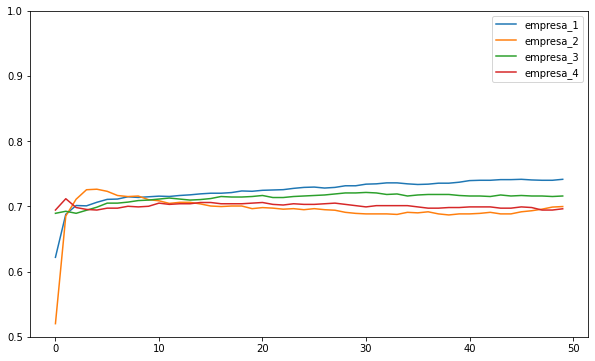

In [10]:
df = pd.read_csv('./results/hito2.csv')
# df["mean"] = df.mean(numeric_only=True, axis=1)

print(f'Acc máximo: {df.mean(numeric_only=True, axis=1).max()}')

f = plt.figure(figsize=(10,6))
ax = f.add_subplot()

df.plot(ax=ax, ylim=(0.5,1))

In [11]:
# Acc máximo: 0.7018698453903198
# 0.7018698453903198

In [15]:
df = pd.read_csv('./results/hito2_UCs_v2.csv')
df

,UC,best_rnd,acc
0,cliente_1.csv,25,0.7167342454195023
1,cliente_2.csv,48,0.7272747308015823
2,cliente_3.csv,25,0.7228885740041733
3,cliente_4.csv,30,0.7135038375854492
4,cliente_5.csv,40,0.7294856309890747
5,cliente_6.csv,14,0.7282231003046036
6,cliente_7.csv,34,0.7234440296888351
7,cliente_8.csv,22,0.7253702878952026
8,cliente_9.csv,23,0.7211103588342667
9,cliente_10.csv,39,0.7132849842309952
